In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


In [6]:
final_df = pd.read_csv("f1_dashboard.csv")
driver_stats = pd.read_csv("driver_season_stats.csv")
constructor_stats = pd.read_csv("constructor_season_stats.csv")


In [10]:
print(f" final_df: {final_df.shape}")
print(f" driver_stats: {driver_stats.shape}")
print(f" constructor_stats: {constructor_stats.shape}")



 final_df: (26759, 36)
 driver_stats: (3211, 13)
 constructor_stats: (1111, 11)


In [8]:
final_df['raceDate'] = pd.to_datetime(final_df['raceDate'])


Feature Engineering for Predictions


In [67]:
# Create lag features for driver and constructor
def create_lag_features(df, group_col, lag_features, lags=[1, 2, 3]):
    """Create lag features for time series"""
    for feature in lag_features:
        for lag in lags:
            df[f'{feature}_lag_{lag}'] = df.groupby(group_col)[feature].shift(lag)
    return df

In [69]:
# Driver features with lags
driver_features = ['wins', 'podiums', 'totalPoints', 'finishRate', 'avgPointsPerRace', 'totalOvertakes']
driver_stats = create_lag_features(driver_stats, 'driver', driver_features, lags=[1, 2, 3])


In [71]:
# Constructor features with lags
constructor_features = ['wins', 'podiums', 'totalPoints', 'finishRate', 'winRate', 'avgPointsPerRace']
constructor_stats = create_lag_features(constructor_stats, 'constructor', constructor_features, lags=[1, 2, 3])


In [73]:
print(f"driver_stats shape after lag features: {driver_stats.shape}")
print(f"constructor_stats shape after lag features: {constructor_stats.shape}")


driver_stats shape after lag features: (3211, 31)
constructor_stats shape after lag features: (1111, 29)


Prepare Data for Race Winner Prediction


In [76]:
# Merge final_df with driver and constructor stats
prediction_df = final_df.copy()
prediction_df = pd.merge(
    prediction_df,
    driver_stats[['year', 'driver', 'totalPoints', 'wins', 'podiums', 'finishRate', 
                  'avgPointsPerRace', 'totalOvertakes', 'wins_lag_1', 'podiums_lag_1',
                  'totalPoints_lag_1', 'wins_lag_2', 'podiums_lag_2']],
    left_on=['year', 'driverRef'],
    right_on=['year', 'driver'],
    how='left'
)


In [78]:
prediction_df = pd.merge(
    prediction_df,
    constructor_stats[['year', 'constructor', 'totalPoints', 'wins', 'finishRate',
                       'wins_lag_1', 'totalPoints_lag_1', 'finishRate_lag_1']],
    left_on=['year', 'constructorRef'],
    right_on=['year', 'constructor'],
    how='left',
    suffixes=('_driver', '_constructor')
)


In [80]:
# Create target variable: Did driver win?
prediction_df['target_win'] = prediction_df['isWin']
prediction_df['target_podium'] = prediction_df['isPodium']
prediction_df['target_points'] = prediction_df['points']


In [84]:
# Sort by driver and race date to create lag features
prediction_df = prediction_df.sort_values(['driverId', 'raceDate'])

In [86]:
# Create lag features for driver performance
prediction_df['wins_lag_1'] = prediction_df.groupby('driverId')['isWin'].shift(1)
prediction_df['podiums_lag_1'] = prediction_df.groupby('driverId')['isPodium'].shift(1)
prediction_df['totalPoints_lag_1'] = prediction_df.groupby('driverId')['points'].shift(1)

In [88]:
# Create cumulative stats for drivers
prediction_df['totalPoints_driver'] = prediction_df.groupby('driverId')['points'].cumsum()
prediction_df['wins_driver'] = prediction_df.groupby('driverId')['isWin'].cumsum()
prediction_df['podiums_driver'] = prediction_df.groupby('driverId')['isPodium'].cumsum()



In [90]:
# Calculate finish rate (proportion of races finished)
prediction_df['races_finished'] = prediction_df.groupby('driverId')['isFinished'].cumsum()
prediction_df['races_count'] = prediction_df.groupby('driverId').cumcount() + 1
prediction_df['finishRate_driver'] = prediction_df['races_finished'] / prediction_df['races_count']


In [92]:
# For constructors (similar approach)
prediction_df['totalPoints_constructor'] = prediction_df.groupby(['constructorId', 'raceId'])['points'].transform('sum')
prediction_df['totalPoints_constructor'] = prediction_df.groupby('constructorId')['totalPoints_constructor'].cumsum()



In [98]:
prediction_df

,raceId,year,round,raceName,raceDate,circuitName,location,country,driverId,driverRef,...,totalPoints_lag_1_constructor,finishRate_lag_1,target_win,target_podium,target_points,wins_lag_1,totalPoints_lag_1,podiums_driver,races_finished,races_count
370,36,2007,1,Australian Grand Prix,2007-03-18,Albert Park Grand Prix Circuit,Melbourne,Australia,1,hamilton,...,151.0,100.0,0,1,6.0,0.0,0.0,1,1,1
391,37,2007,2,Malaysian Grand Prix,2007-04-08,Sepang International Circuit,Kuala Lumpur,Malaysia,1,hamilton,...,151.0,100.0,0,1,8.0,0.0,6.0,2,2,2
413,38,2007,3,Bahrain Grand Prix,2007-04-15,Bahrain International Circuit,Sakhir,Bahrain,1,hamilton,...,151.0,100.0,0,1,8.0,0.0,8.0,3,3,3
435,39,2007,4,Spanish Grand Prix,2007-05-13,Circuit de Barcelona-Catalunya,Montmeló,Spain,1,hamilton,...,151.0,100.0,0,1,8.0,0.0,8.0,4,4,4
457,40,2007,5,Monaco Grand Prix,2007-05-27,Circuit de Monaco,Monte-Carlo,Monaco,1,hamilton,...,151.0,100.0,0,1,8.0,0.0,8.0,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26695,1141,2024,21,São Paulo Grand Prix,2024-11-03,Autódromo José Carlos Pace,São Paulo,Brazil,861,colapinto,...,NaN,95.0,0,0,0.0,0.0,0.0,0,6,6
26712,1142,2024,22,Las Vegas Grand Prix,2024-11-23,Las Vegas Strip Street Circuit,Las Vegas,United States,861,colapinto,...,NaN,95.0,0,0,0.0,0.0,0.0,0,7,7
26737,1143,2024,23,Qatar Grand Prix,2024-12-01,Losail International Circuit,Al Daayen,Qatar,861,colapinto,...,NaN,95.0,0,0,0.0,0.0,0.0,0,7,8
26757,1144,2024,24,Abu Dhabi Grand Prix,2024-12-08,Yas Marina Circuit,Abu Dhabi,UAE,861,colapinto,...,NaN,95.0,0,0,0.0,0.0,0.0,0,8,9


In [94]:
# Select features for modeling
feature_cols = [
    'grid', 'qualPosition', 'gridToFinish', 'qualToRaceChange', 
    'avgLapTime', 'lapTimeConsistency', 'pitStopsCount', 
    'avgPitStopDuration', 'overtakesCount',
    'totalPoints_driver', 'wins_driver', 'podiums_driver', 'finishRate_driver',
    'avgPointsPerRace', 'totalOvertakes',
    'wins_lag_1', 'podiums_lag_1', 'totalPoints_lag_1',
    'totalPoints_constructor', 'wins_constructor', 'finishRate_constructor',
    'finishRate_lag_1'
]

# Fill NaN values
prediction_df[feature_cols] = prediction_df[feature_cols].fillna(prediction_df[feature_cols].median())


In [96]:
X = prediction_df[feature_cols].copy()
y_win = prediction_df['target_win'].values
y_podium = prediction_df['target_podium'].values
y_points = prediction_df['target_points'].values

In [100]:
print(f" Prediction dataset prepared!")
print(f"Features shape: {X.shape}")
print(f"Win prediction samples: {y_win.sum()} wins out of {len(y_win)} races")

 Prediction dataset prepared!
Features shape: (26759, 22)
Win prediction samples: 1128 wins out of 26759 races


Scale Features


In [102]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f" Features scaled!")
print(f"Feature mean: {X_scaled.mean():.6f}, std: {X_scaled.std():.6f}")


 Features scaled!
Feature mean: 0.000000, std: 1.000000


Train-Test Split (Time Series Split)


In [104]:
# Use time series split to avoid look-ahead bias
tscv = TimeSeriesSplit(n_splits=3)
train_idx, test_idx = list(tscv.split(X_scaled))[-1]

X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train_win, y_test_win = y_win[train_idx], y_win[test_idx]
y_train_podium, y_test_podium = y_podium[train_idx], y_podium[test_idx]
y_train_points, y_test_points = y_points[train_idx], y_points[test_idx]

In [106]:
print(f" Train-Test split completed!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Feature dimensions: {X_train.shape[1]}")


 Train-Test split completed!
Training samples: 20070
Testing samples: 6689
Feature dimensions: 22


Deep Learning Model - Race Winner Prediction


In [117]:
def build_winner_model(input_shape):
    """Build deep neural network for winner prediction"""
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model





In [119]:
# Build and train
nn_winner = build_winner_model(X_train.shape[1])
print(nn_winner.summary())

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history_winner = nn_winner.fit(
    X_train, y_train_win,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,721 (57.50 KB)

 Trainable params: 14,273 (55.75 KB)

 Non-trainable params: 448 (1.75 KB)

None


Deep Learning Model - Podium Prediction


In [122]:
nn_podium = build_winner_model(X_train.shape[1])
history_podium = nn_podium.fit(
    X_train, y_train_podium,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)


In [124]:
print(nn_podium.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,269 (169.02 KB)

 Trainable params: 14,273 (55.75 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 28,548 (111.52 KB)

None


Deep Learning Model - Points Regression

In [126]:
def build_points_model(input_shape):
    """Build deep neural network for points regression"""
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='relu')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [128]:
nn_points = build_points_model(X_train.shape[1])
history_points = nn_points.fit(
    X_train, y_train_points,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

In [130]:
print(nn_points.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,013 (168.02 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 28,420 (111.02 KB)

None


Traditional ML Models for Comparison

In [132]:
# Random Forest for winner prediction
rf_winner = RandomForestClassifier(n_estimators=200, max_depth=20, 
                                   random_state=42, n_jobs=-1)
rf_winner.fit(X_train, y_train_win)


RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [134]:
# Gradient Boosting for winner prediction
gb_winner = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, 
                                       max_depth=7, random_state=42)
gb_winner.fit(X_train, y_train_win)


GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=42)

In [136]:
# Random Forest for points prediction
rf_points = RandomForestRegressor(n_estimators=200, max_depth=20, 
                                  random_state=42, n_jobs=-1)
rf_points.fit(X_train, y_train_points)

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1,
                      random_state=42)

Model Predictions


In [138]:
# Deep Learning Predictions
y_pred_nn_win = nn_winner.predict(X_test, verbose=0).flatten()
y_pred_nn_win_binary = (y_pred_nn_win > 0.5).astype(int)

y_pred_nn_podium = nn_podium.predict(X_test, verbose=0).flatten()
y_pred_nn_podium_binary = (y_pred_nn_podium > 0.5).astype(int)

y_pred_nn_points = nn_points.predict(X_test, verbose=0).flatten()


In [140]:
# Random Forest Predictions
y_pred_rf_win = rf_winner.predict(X_test)
y_pred_rf_win_proba = rf_winner.predict_proba(X_test)[:, 1]

y_pred_rf_points = rf_points.predict(X_test)


In [142]:
# Gradient Boosting Predictions
y_pred_gb_win = gb_winner.predict(X_test)
y_pred_gb_win_proba = gb_winner.predict_proba(X_test)[:, 1]


Evaluate Winner Prediction Models


In [150]:
# Import all required metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix, 
    precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

def evaluate_classifier(y_true, y_pred_proba, y_pred_binary, model_name):
    """Evaluate classification model"""
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred_binary, zero_division=0))
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
            'roc_auc': roc_auc, 'f1': f1}

# Evaluate your models
results_winner = {}
results_winner['NN'] = evaluate_classifier(y_test_win, y_pred_nn_win, y_pred_nn_win_binary, "Neural Network")
results_winner['RF'] = evaluate_classifier(y_test_win, y_pred_rf_win_proba, y_pred_rf_win, "Random Forest")
results_winner['GB'] = evaluate_classifier(y_test_win, y_pred_gb_win_proba, y_pred_gb_win, "Gradient Boosting")

# Compare results
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
for model_name, metrics in results_winner.items():
    print(f"{model_name}: AUC={metrics['roc_auc']:.4f}, F1={metrics['f1']:.4f}, Accuracy={metrics['accuracy']:.4f}")


Neural Network Performance:
Accuracy: 0.9979
Precision: 0.9569
Recall: 0.9756
F1-Score: 0.9662
ROC AUC: 0.9997

Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6484
           1       0.96      0.98      0.97       205

    accuracy                           1.00      6689
   macro avg       0.98      0.99      0.98      6689
weighted avg       1.00      1.00      1.00      6689


Random Forest Performance:
Accuracy: 0.9934
Precision: 1.0000
Recall: 0.7854
F1-Score: 0.8798
ROC AUC: 0.9990

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6484
           1       1.00      0.79      0.88       205

    accuracy                           0.99      6689
   macro avg       1.00      0.89      0.94      6689
weighted avg       0.99      0.99      0.99      6689


Gradient Boosting Performance:
Accura

Evaluate Points Regression Models


In [156]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
import numpy as np

def evaluate_regressor(y_true, y_pred, model_name):
    """Evaluate regression model with comprehensive metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MedAE: {medae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'medae': medae, 'mape': mape}

# Evaluate your regression models
results_points = {}
results_points['NN'] = evaluate_regressor(y_test_points, y_pred_nn_points, "Neural Network")
results_points['RF'] = evaluate_regressor(y_test_points, y_pred_rf_points, "Random Forest")


# Compare results
print("\n" + "="*60)
print("REGRESSION MODEL COMPARISON SUMMARY")
print("="*60)
for model_name, metrics in results_points.items():
    print(f"{model_name}:")
    print(f"  MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}, R²: {metrics['r2']:.4f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")


Neural Network Performance:
MAE: 0.3610
MSE: 0.9112
RMSE: 0.9546
R²: 0.9659
MedAE: 0.0000
MAPE: 186528882.72%

Random Forest Performance:
MAE: 0.4372
MSE: 1.3668
RMSE: 1.1691
R²: 0.9489
MedAE: 0.0300
MAPE: 560420550.62%

REGRESSION MODEL COMPARISON SUMMARY
NN:
  MAE: 0.3610, RMSE: 0.9546, R²: 0.9659
  MAPE: 186528882.72%
RF:
  MAE: 0.4372, RMSE: 1.1691, R²: 0.9489
  MAPE: 560420550.62%


Visualize Training History


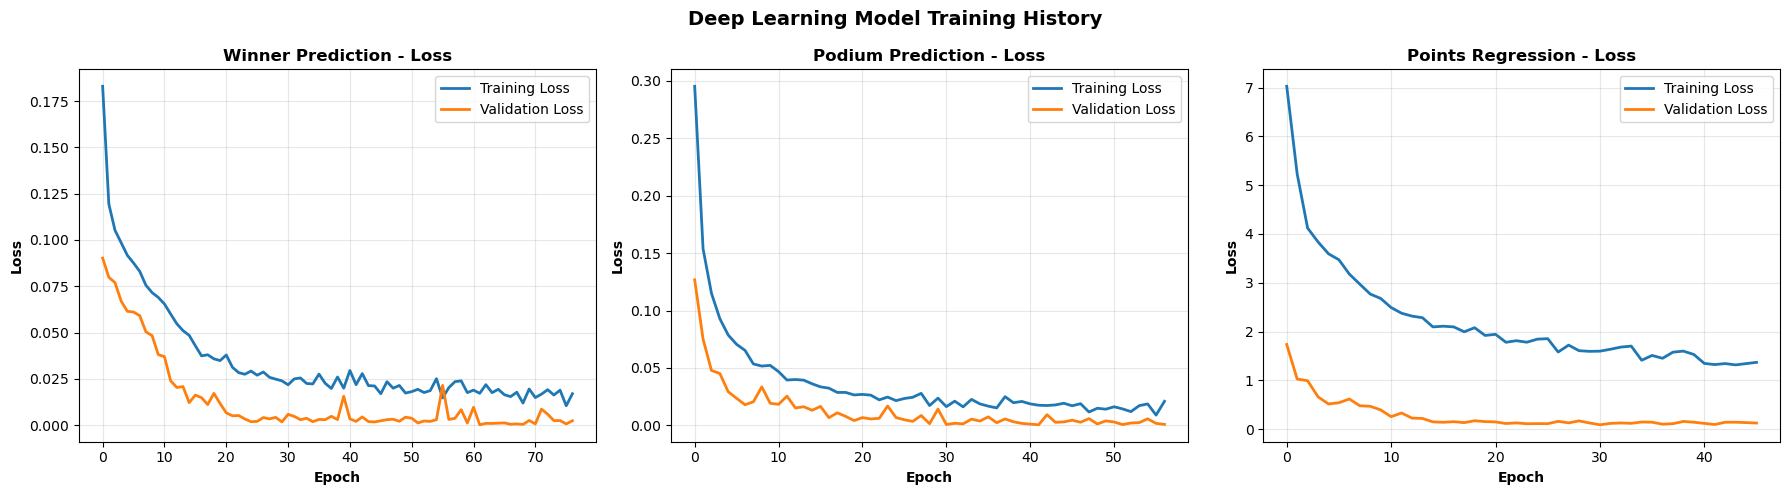

Training history visualization complete!


In [158]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Deep Learning Model Training History', fontsize=14, fontweight='bold')

# Winner model
ax = axes[0]
ax.plot(history_winner.history['loss'], label='Training Loss', linewidth=2)
ax.plot(history_winner.history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Loss', fontweight='bold')
ax.set_title('Winner Prediction - Loss', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Podium model
ax = axes[1]
ax.plot(history_podium.history['loss'], label='Training Loss', linewidth=2)
ax.plot(history_podium.history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Loss', fontweight='bold')
ax.set_title('Podium Prediction - Loss', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Points model
ax = axes[2]
ax.plot(history_points.history['loss'], label='Training Loss', linewidth=2)
ax.plot(history_points.history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Loss', fontweight='bold')
ax.set_title('Points Regression - Loss', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Training history visualization complete!")

Model Comparison Visualization

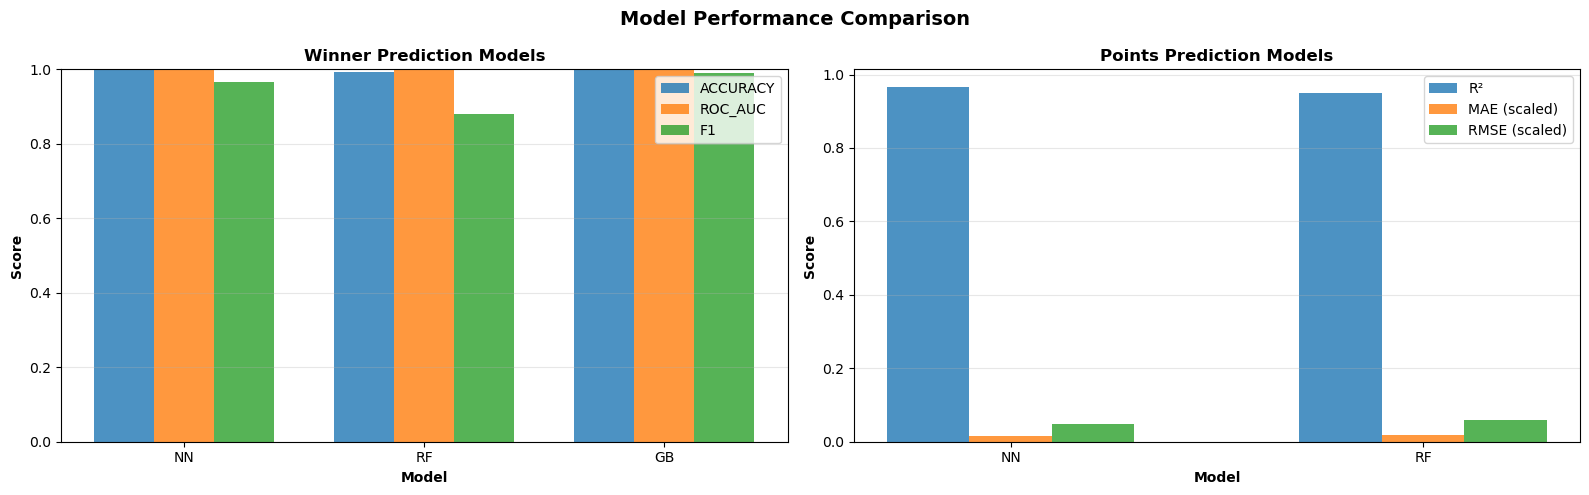

 Model comparison visualization complete!


In [160]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')

# Winner prediction comparison
ax = axes[0]
models_winner = list(results_winner.keys())
metrics = ['accuracy', 'roc_auc', 'f1']
x = np.arange(len(models_winner))
width = 0.25

for i, metric in enumerate(metrics):
    values = [results_winner[model][metric] for model in models_winner]
    ax.bar(x + i*width, values, width, label=metric.upper(), alpha=0.8)

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Winner Prediction Models', fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(models_winner)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Points prediction comparison
ax = axes[1]
models_points = list(results_points.keys())
metrics_reg = ['r2', 'mae', 'rmse']
x = np.arange(len(models_points))

r2_vals = [results_points[model]['r2'] for model in models_points]
mae_vals = [results_points[model]['mae'] / 25 for model in models_points]  # Scale for visibility
rmse_vals = [results_points[model]['rmse'] / 20 for model in models_points]

ax.bar(x - 0.2, r2_vals, 0.2, label='R²', alpha=0.8)
ax.bar(x, [m for m in mae_vals], 0.2, label='MAE (scaled)', alpha=0.8)
ax.bar(x + 0.2, rmse_vals, 0.2, label='RMSE (scaled)', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Points Prediction Models', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_points)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(" Model comparison visualization complete!")


ROC Curves for Winner Prediction


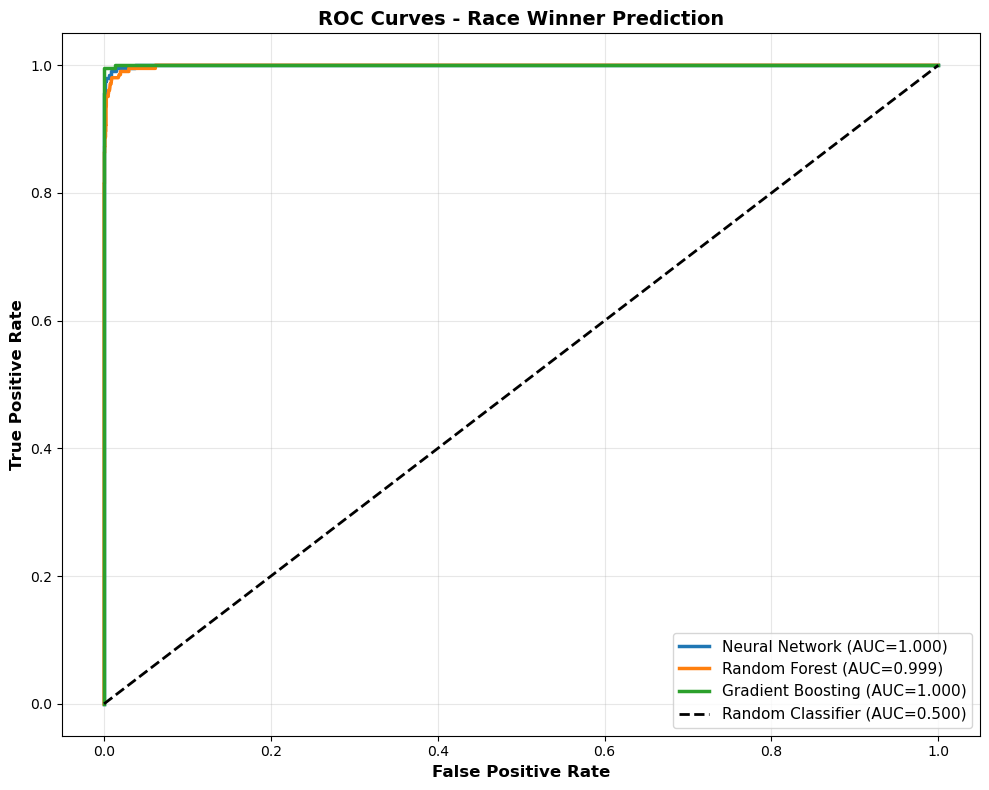

 ROC curves visualization complete!


In [162]:
fig, ax = plt.subplots(figsize=(10, 8))

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test_win, y_pred_nn_win)
roc_auc_nn = roc_auc_score(y_test_win, y_pred_nn_win)
ax.plot(fpr_nn, tpr_nn, linewidth=2.5, label=f'Neural Network (AUC={roc_auc_nn:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_win, y_pred_rf_win_proba)
roc_auc_rf = roc_auc_score(y_test_win, y_pred_rf_win_proba)
ax.plot(fpr_rf, tpr_rf, linewidth=2.5, label=f'Random Forest (AUC={roc_auc_rf:.3f})')

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test_win, y_pred_gb_win_proba)
roc_auc_gb = roc_auc_score(y_test_win, y_pred_gb_win_proba)
ax.plot(fpr_gb, tpr_gb, linewidth=2.5, label=f'Gradient Boosting (AUC={roc_auc_gb:.3f})')

# Random classifier
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC=0.500)')

ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
ax.set_title('ROC Curves - Race Winner Prediction', fontweight='bold', fontsize=14)
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(" ROC curves visualization complete!")


Feature Importance Analysis

In [164]:
# Get feature importance from Random Forest
feature_importance = rf_winner.feature_importances_
feature_names = feature_cols
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)


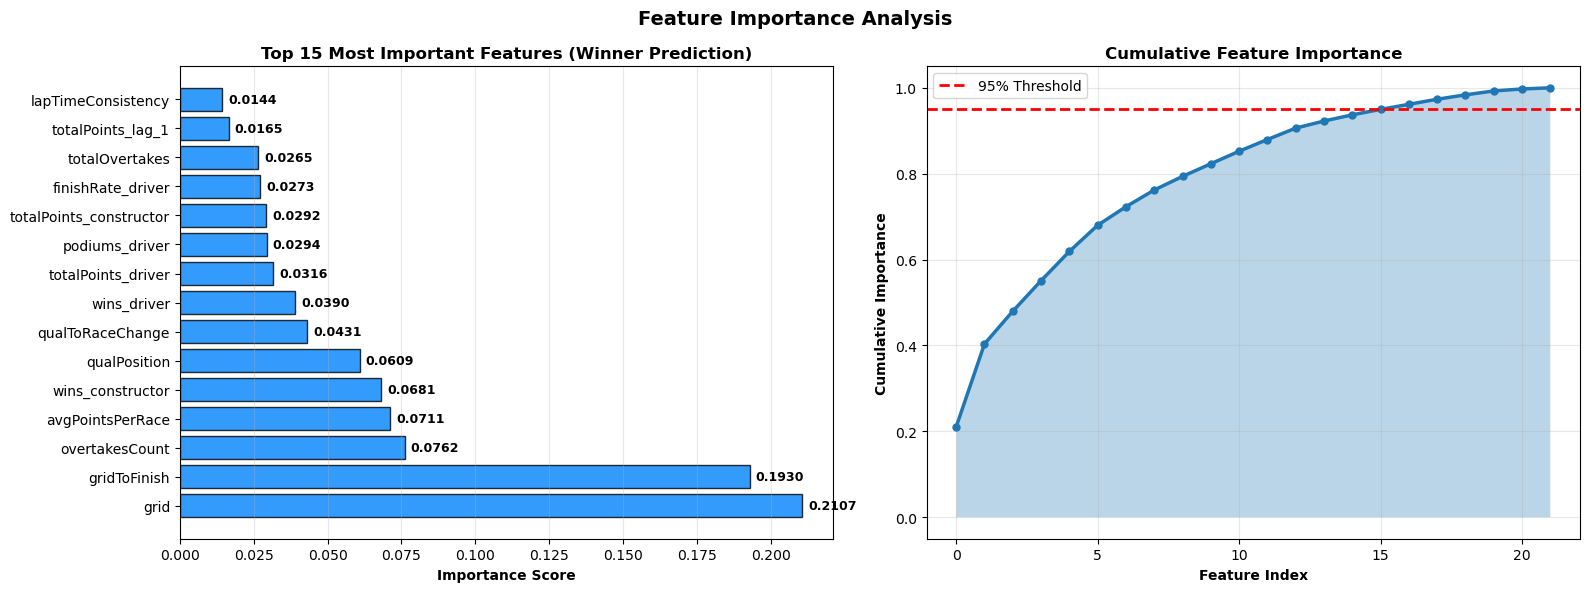

 Feature importance analysis complete!


In [166]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance Analysis', fontsize=14, fontweight='bold')

# Top 15 features
ax = axes[0]
top_features = importance_df.head(15)
ax.barh(range(len(top_features)), top_features['importance'].values, color='#0082FA', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance Score', fontweight='bold')
ax.set_title('Top 15 Most Important Features (Winner Prediction)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(top_features['importance'].values):
    ax.text(v + 0.002, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

# Cumulative importance
ax = axes[1]
cumsum_importance = np.cumsum(importance_df['importance'].values)
ax.plot(range(len(cumsum_importance)), cumsum_importance, marker='o', linewidth=2.5, markersize=5)
ax.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Threshold')
ax.fill_between(range(len(cumsum_importance)), cumsum_importance, alpha=0.3)
ax.set_xlabel('Feature Index', fontweight='bold')
ax.set_ylabel('Cumulative Importance', fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(" Feature importance analysis complete!")

Confusion Matrix Visualization

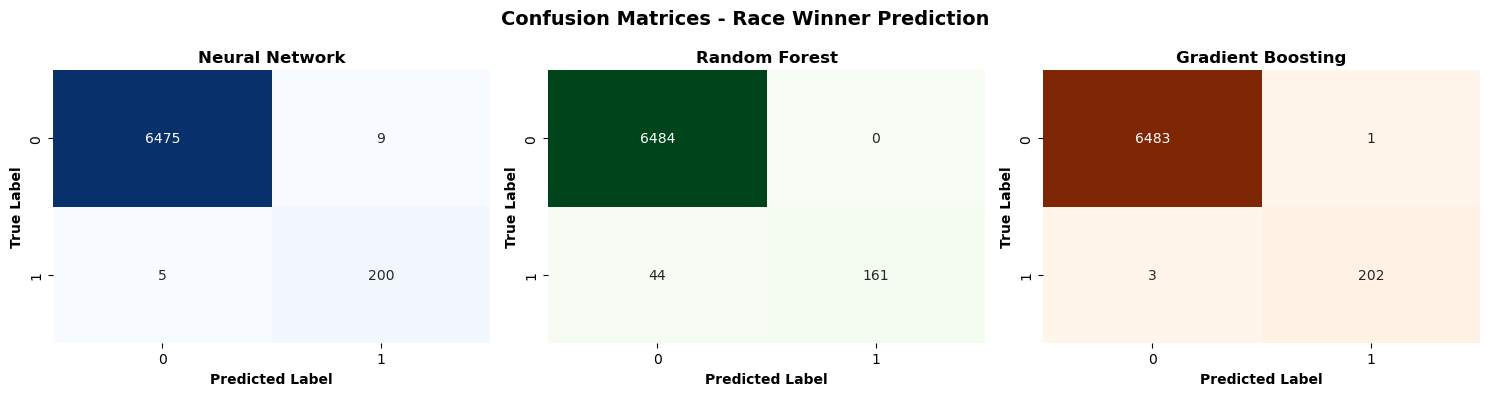

 Confusion matrix visualization complete!


In [168]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices - Race Winner Prediction', fontsize=14, fontweight='bold')

# Neural Network
cm_nn = confusion_matrix(y_test_win, y_pred_nn_win_binary)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Neural Network', fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Random Forest
cm_rf = confusion_matrix(y_test_win, y_pred_rf_win)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Random Forest', fontweight='bold')
axes[1].set_ylabel('True Label', fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontweight='bold')

# Gradient Boosting
cm_gb = confusion_matrix(y_test_win, y_pred_gb_win)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
axes[2].set_title('Gradient Boosting', fontweight='bold')
axes[2].set_ylabel('True Label', fontweight='bold')
axes[2].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Confusion matrix visualization complete!")


In [ ]:
Actual vs Predicted - Points Prediction


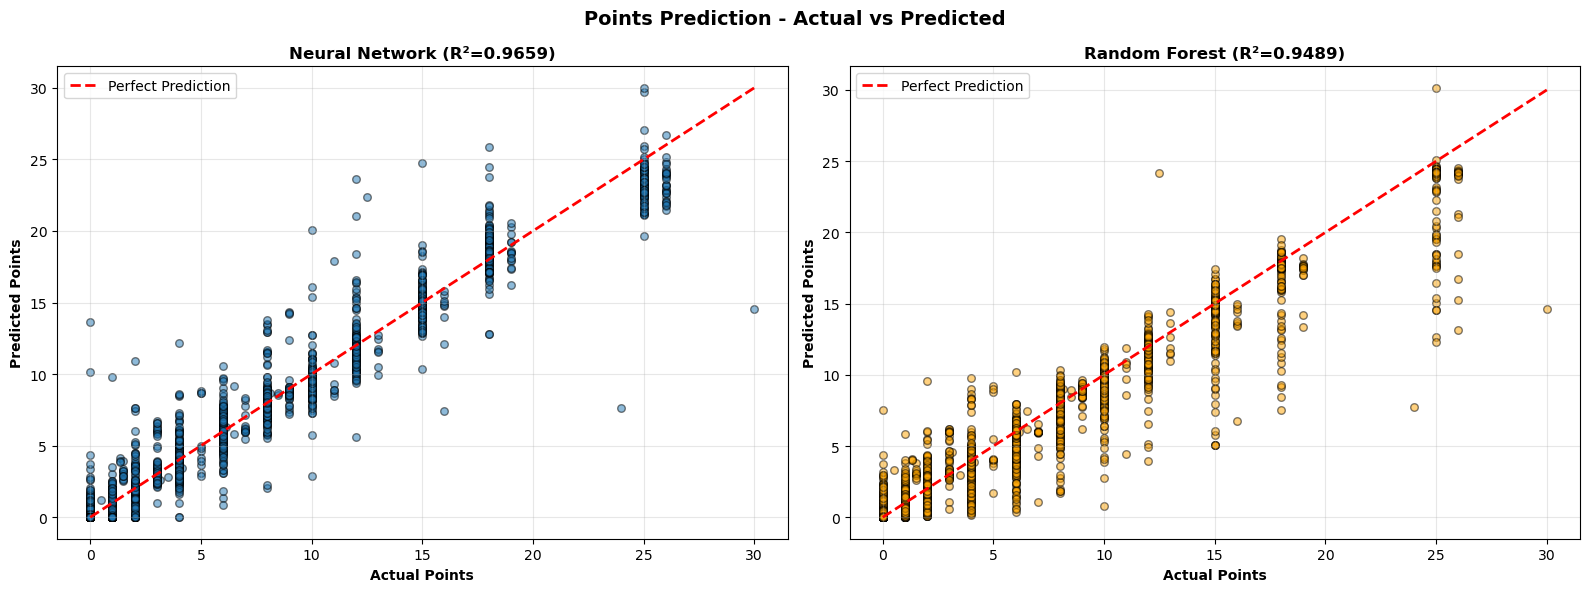

Points prediction visualization complete!


In [170]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Points Prediction - Actual vs Predicted', fontsize=14, fontweight='bold')

# Neural Network
ax = axes[0]
ax.scatter(y_test_points, y_pred_nn_points, alpha=0.5, s=30, edgecolors='black')
ax.plot([y_test_points.min(), y_test_points.max()], 
        [y_test_points.min(), y_test_points.max()], 
        'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Points', fontweight='bold')
ax.set_ylabel('Predicted Points', fontweight='bold')
ax.set_title(f'Neural Network (R²={results_points["NN"]["r2"]:.4f})', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Random Forest
ax = axes[1]
ax.scatter(y_test_points, y_pred_rf_points, alpha=0.5, s=30, edgecolors='black', color='orange')
ax.plot([y_test_points.min(), y_test_points.max()], 
        [y_test_points.min(), y_test_points.max()], 
        'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Points', fontweight='bold')
ax.set_ylabel('Predicted Points', fontweight='bold')
ax.set_title(f'Random Forest (R²={results_points["RF"]["r2"]:.4f})', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Points prediction visualization complete!")


Model Summary Report


In [172]:
summary_data = {
    'Model': ['Neural Network', 'Random Forest', 'Gradient Boosting'],
    'Task': ['Winner', 'Winner', 'Winner'],
    'Accuracy': [results_winner['NN']['accuracy'], results_winner['RF']['accuracy'], results_winner['GB']['accuracy']],
    'ROC-AUC': [results_winner['NN']['roc_auc'], results_winner['RF']['roc_auc'], results_winner['GB']['roc_auc']],
    'F1-Score': [results_winner['NN']['f1'], results_winner['RF']['f1'], results_winner['GB']['f1']]
}

summary_df = pd.DataFrame(summary_data)


In [176]:
print(summary_df.to_string(index=False))

            Model   Task  Accuracy  ROC-AUC  F1-Score
   Neural Network Winner  0.997907 0.999651  0.966184
    Random Forest Winner  0.993422 0.998994  0.879781
Gradient Boosting Winner  0.999402 0.999934  0.990196


In [178]:
points_summary = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest'],
    'MAE': [results_points['NN']['mae'], results_points['RF']['mae']],
    'RMSE': [results_points['NN']['rmse'], results_points['RF']['rmse']],
    'R²': [results_points['NN']['r2'], results_points['RF']['r2']]
})
print(points_summary.to_string(index=False))


         Model      MAE     RMSE       R²
Neural Network 0.360973 0.954565 0.965931
 Random Forest 0.437218 1.169117 0.948894


Prediction on Recent Races

In [180]:
# Get most recent races
recent_races = prediction_df[prediction_df['year'] == prediction_df['year'].max()].copy()
recent_races = recent_races[recent_races['round'] == recent_races['round'].max()]

if len(recent_races) > 0:
    recent_X = recent_races[feature_cols].fillna(recent_races[feature_cols].median())
    recent_X_scaled = scaler.transform(recent_X)
    
    # Get predictions
    recent_pred_nn_win = nn_winner.predict(recent_X_scaled, verbose=0).flatten()
    recent_pred_rf_win = rf_winner.predict_proba(recent_X_scaled)[:, 1]
    recent_pred_gb_win = gb_winner.predict_proba(recent_X_scaled)[:, 1]
    
    recent_pred_nn_points = nn_points.predict(recent_X_scaled, verbose=0).flatten()
    recent_pred_rf_points = rf_points.predict(recent_X_scaled)
    
    # Create results dataframe
    recent_results = pd.DataFrame({
        'Driver': recent_races['driverRef'].values,
        'Constructor': recent_races['constructorRef'].values,
        'Grid': recent_races['grid'].values,
        'NN_Win_Prob': recent_pred_nn_win,
        'RF_Win_Prob': recent_pred_rf_win,
        'GB_Win_Prob': recent_pred_gb_win,
        'Ensemble_Win_Prob': (recent_pred_nn_win + recent_pred_rf_win + recent_pred_gb_win) / 3,
        'NN_Predicted_Points': recent_pred_nn_points,
        'RF_Predicted_Points': recent_pred_rf_points,
        'Ensemble_Points': (recent_pred_nn_points + recent_pred_rf_points) / 2
    }).sort_values('Ensemble_Win_Prob', ascending=False)


In [184]:
print(f"Predictions for Recent Race (Year: {prediction_df['year'].max()}):\n")
print(recent_results[['Driver', 'Constructor', 'Grid', 'Ensemble_Win_Prob', 'Ensemble_Points']].head(10))

Predictions for Recent Race (Year: 2024):

            Driver Constructor  Grid  Ensemble_Win_Prob  Ensemble_Points
11          norris     mclaren     1           0.966746        23.823263
10         leclerc     ferrari    19           0.042252        12.967295
7            sainz     ferrari     3           0.028440        17.857733
0         hamilton    mercedes    16           0.018381        11.298576
12         russell    mercedes     6           0.018334         9.346336
16         piastri     mclaren     2           0.008334         0.707500
6   max_verstappen    red_bull     4           0.003352         8.520913
9            gasly      alpine     5           0.001667         4.693181
13           albon    williams    18           0.001667         0.077500
4           bottas      sauber     9           0.001667         0.000000


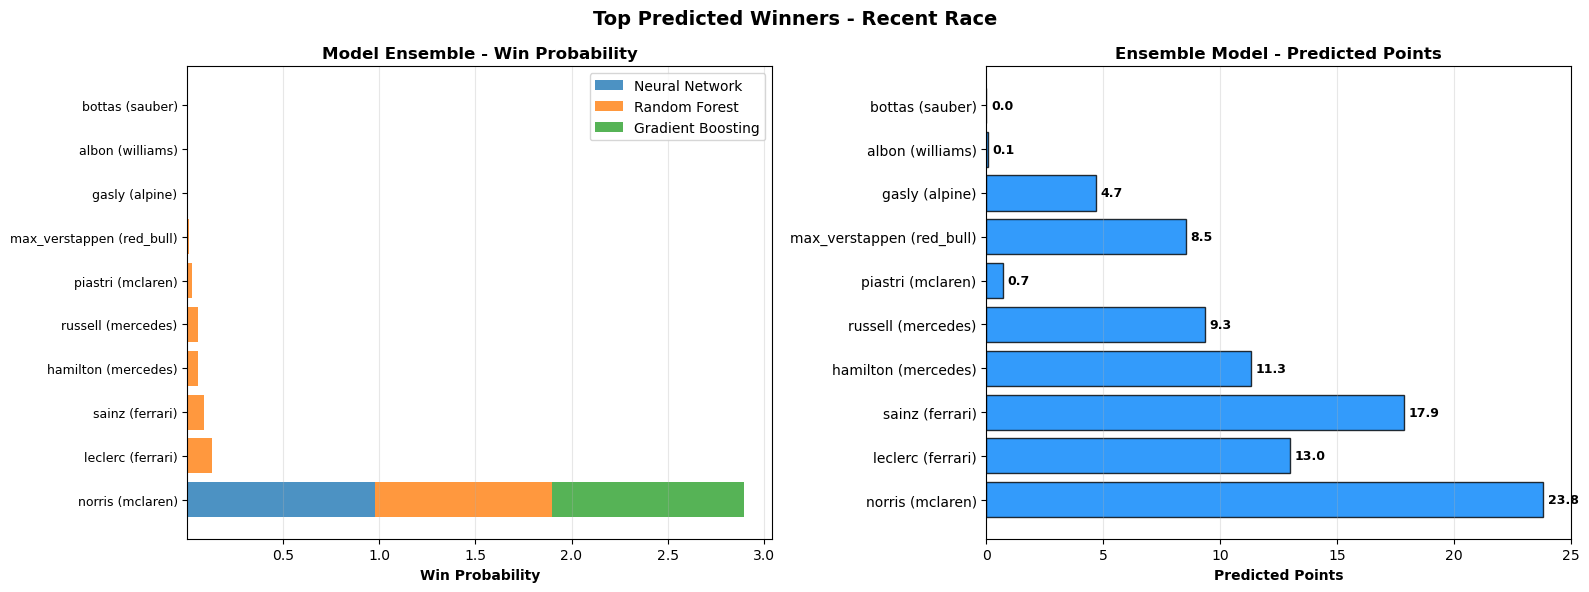


 Recent race predictions visualization complete!


In [190]:
# Check if there are recent races to visualize
if 'recent_results' in locals() and recent_results is not None and len(recent_results) > 0:
    # Visualize top predicted winners
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Top Predicted Winners - Recent Race', fontsize=14, fontweight='bold')
    
    top_n = 10
    top_winners = recent_results.head(top_n)
    
    # Win probability
    ax = axes[0]
    drivers = [f"{d} ({c})" for d, c in zip(top_winners['Driver'], top_winners['Constructor'])]
    x_pos = np.arange(len(drivers))
    
    ax.barh(x_pos, top_winners['NN_Win_Prob'], label='Neural Network', alpha=0.8)
    ax.barh(x_pos, top_winners['RF_Win_Prob'], left=top_winners['NN_Win_Prob'], label='Random Forest', alpha=0.8)
    ax.barh(x_pos, top_winners['GB_Win_Prob'], 
            left=top_winners['NN_Win_Prob'] + top_winners['RF_Win_Prob'], label='Gradient Boosting', alpha=0.8)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(drivers, fontsize=9)
    ax.set_xlabel('Win Probability', fontweight='bold')
    ax.set_title('Model Ensemble - Win Probability', fontweight='bold')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    
    # Predicted points
    ax = axes[1]
    ax.barh(drivers, top_winners['Ensemble_Points'], color='#0082FA', edgecolor='black', alpha=0.8)
    ax.set_xlabel('Predicted Points', fontweight='bold')
    ax.set_title('Ensemble Model - Predicted Points', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(top_winners['Ensemble_Points'].values):
        ax.text(v + 0.2, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Recent race predictions visualization complete!")
else:
    print("  No recent races found in prediction data")

Driver Trend Analysis


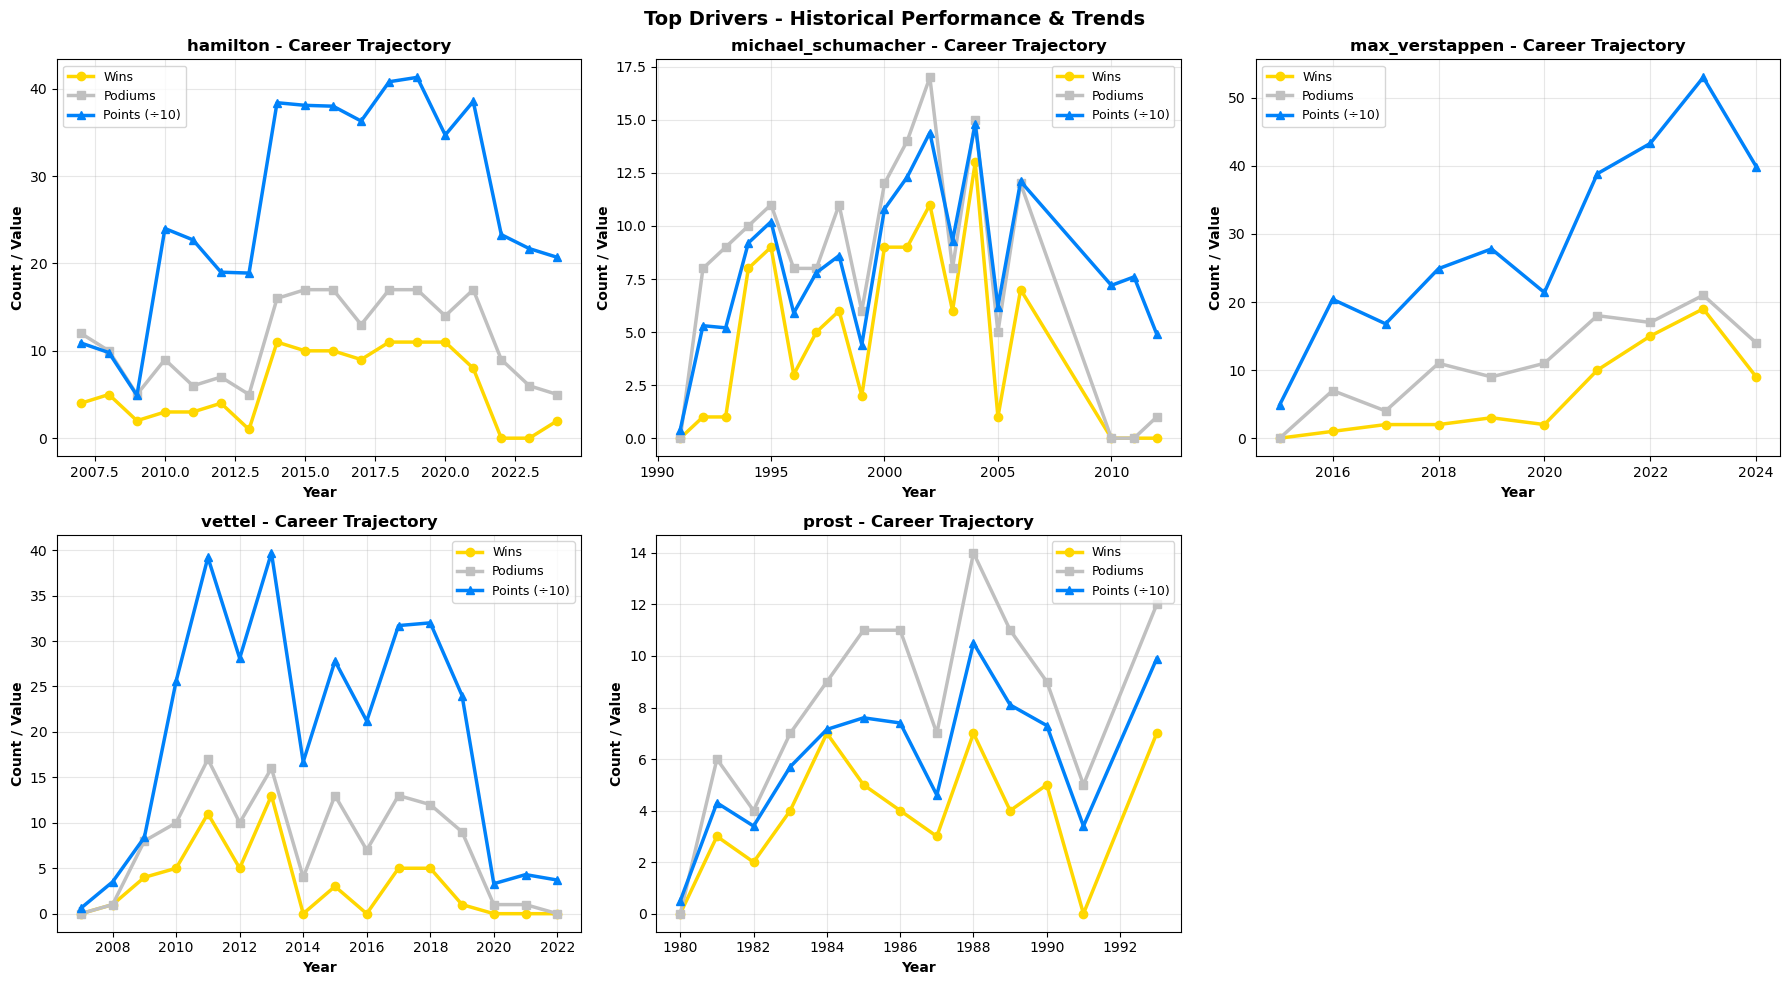

 Driver trend analysis complete!


In [192]:
# Get top drivers
top_drivers_list = prediction_df[prediction_df['isWin'] == 1]['driverRef'].value_counts().head(5).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Top Drivers - Historical Performance & Trends', fontsize=14, fontweight='bold')
axes = axes.flatten()

for idx, driver in enumerate(top_drivers_list):
    ax = axes[idx]
    
    driver_data = driver_stats[driver_stats['driver'] == driver].sort_values('year')
    
    ax.plot(driver_data['year'], driver_data['wins'], marker='o', linewidth=2.5, 
            label='Wins', markersize=6, color='#FFD700')
    ax.plot(driver_data['year'], driver_data['podiums'], marker='s', linewidth=2.5, 
            label='Podiums', markersize=6, color='#C0C0C0')
    ax.plot(driver_data['year'], driver_data['totalPoints'] / 10, marker='^', linewidth=2.5, 
            label='Points (÷10)', markersize=6, color='#0082FA')
    
    ax.set_xlabel('Year', fontweight='bold')
    ax.set_ylabel('Count / Value', fontweight='bold')
    ax.set_title(f'{driver} - Career Trajectory', fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print(" Driver trend analysis complete!")

Constructor Championship Predictions


In [194]:
# Get constructor performance for recent season
recent_year = prediction_df['year'].max()
recent_constructors = prediction_df[prediction_df['year'] == recent_year].copy()

constructor_pred = recent_constructors.groupby('constructorRef').agg({
    'points': 'sum',
    'isWin': 'sum',
    'isPodium': 'sum',
    'raceId': 'count'
}).reset_index()

constructor_pred.columns = ['Constructor', 'Total_Points', 'Wins', 'Podiums', 'Races']
constructor_pred = constructor_pred.sort_values('Total_Points', ascending=False)

print(f"\nConstructor Standings - Season {recent_year}:\n")
print(constructor_pred.head(15).to_string(index=False))




Constructor Standings - Season 2024:

 Constructor  Total_Points  Wins  Podiums  Races
     mclaren         609.0     6       21     48
     ferrari         595.0     5       22     48
    red_bull         537.0     9       18     48
    mercedes         433.0     4        9     48
aston_martin          94.0     0        0     48
      alpine          63.0     0        2     48
        haas          51.0     0        0     48
          rb          40.0     0        0     48
    williams          17.0     0        0     47
      sauber           4.0     0        0     48


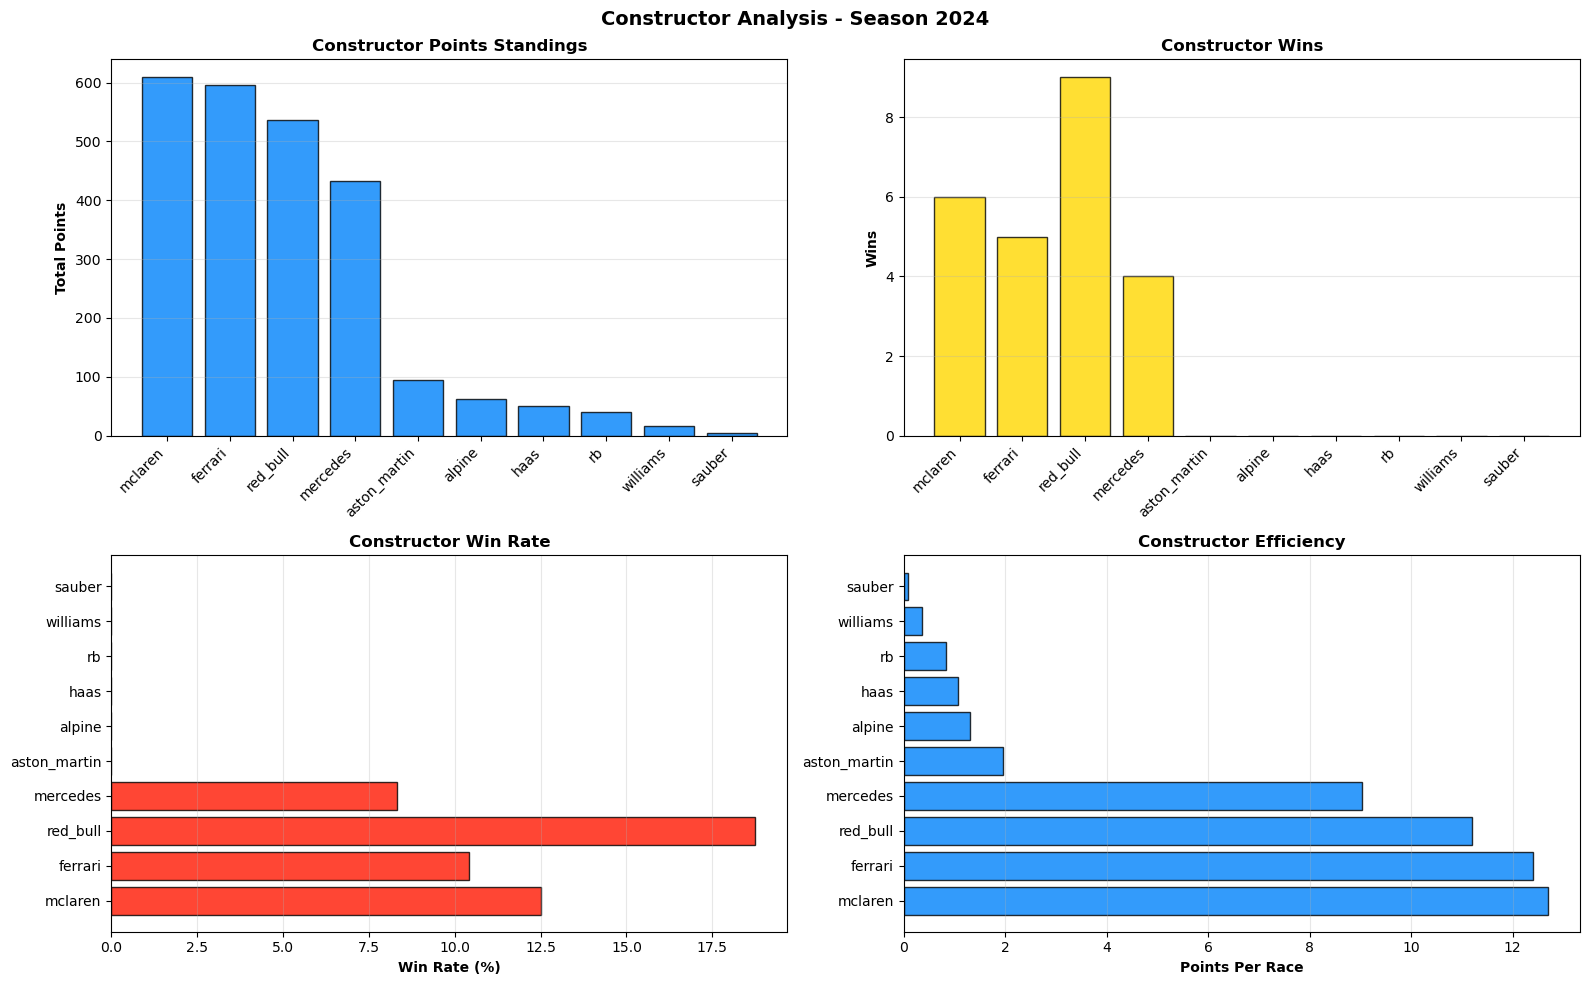


 Constructor championship analysis complete!


In [196]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Constructor Analysis - Season {recent_year}', fontsize=14, fontweight='bold')

top_n_const = 10

# Points comparison
ax = axes[0, 0]
top_const = constructor_pred.head(top_n_const)
ax.bar(range(len(top_const)), top_const['Total_Points'], color='#0082FA', edgecolor='black', alpha=0.8)
ax.set_xticks(range(len(top_const)))
ax.set_xticklabels(top_const['Constructor'], rotation=45, ha='right')
ax.set_ylabel('Total Points', fontweight='bold')
ax.set_title('Constructor Points Standings', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Wins comparison
ax = axes[0, 1]
ax.bar(range(len(top_const)), top_const['Wins'], color='#FFD700', edgecolor='black', alpha=0.8)
ax.set_xticks(range(len(top_const)))
ax.set_xticklabels(top_const['Constructor'], rotation=45, ha='right')
ax.set_ylabel('Wins', fontweight='bold')
ax.set_title('Constructor Wins', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Win rate
ax = axes[1, 0]
top_const['win_rate'] = (top_const['Wins'] / top_const['Races'] * 100).round(2)
ax.barh(top_const['Constructor'], top_const['win_rate'], color='#FF1801', edgecolor='black', alpha=0.8)
ax.set_xlabel('Win Rate (%)', fontweight='bold')
ax.set_title('Constructor Win Rate', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Points per race
ax = axes[1, 1]
top_const['points_per_race'] = (top_const['Total_Points'] / top_const['Races']).round(2)
ax.barh(top_const['Constructor'], top_const['points_per_race'], color='#0082FA', edgecolor='black', alpha=0.8)
ax.set_xlabel('Points Per Race', fontweight='bold')
ax.set_title('Constructor Efficiency', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Constructor championship analysis complete!")

Predictive Insights - Performance Under Pressure


In [198]:
# Analyze how drivers perform based on grid position
grid_analysis = prediction_df.groupby('grid').agg({
    'isWin': 'sum',
    'isPodium': 'sum',
    'points': 'mean',
    'driverId': 'count',
    'gridToFinish': 'mean'
}).reset_index()
grid_analysis.columns = ['Grid_Position', 'Wins_From_Position', 'Podiums_From_Position', 
                        'Avg_Points', 'Total_Races', 'Avg_Position_Change']
grid_analysis = grid_analysis[grid_analysis['Grid_Position'] <= 20]



In [200]:
grid_analysis

,Grid_Position,Wins_From_Position,Podiums_From_Position,Avg_Points,Total_Races,Avg_Position_Change
0,0,0,0,0.031746,1638,27.139805
1,1,481,721,8.601796,1136,4.663732
2,2,268,626,7.129902,1125,4.611556
3,3,137,523,5.798796,1130,4.505310
4,4,68,386,4.810071,1132,4.231449
5,5,49,283,3.814037,1132,4.136042
6,6,40,209,3.334222,1125,3.574222
7,7,23,147,2.528194,1135,3.066960
8,8,17,112,2.010186,1129,2.688220
9,9,5,94,1.832597,1132,1.803887


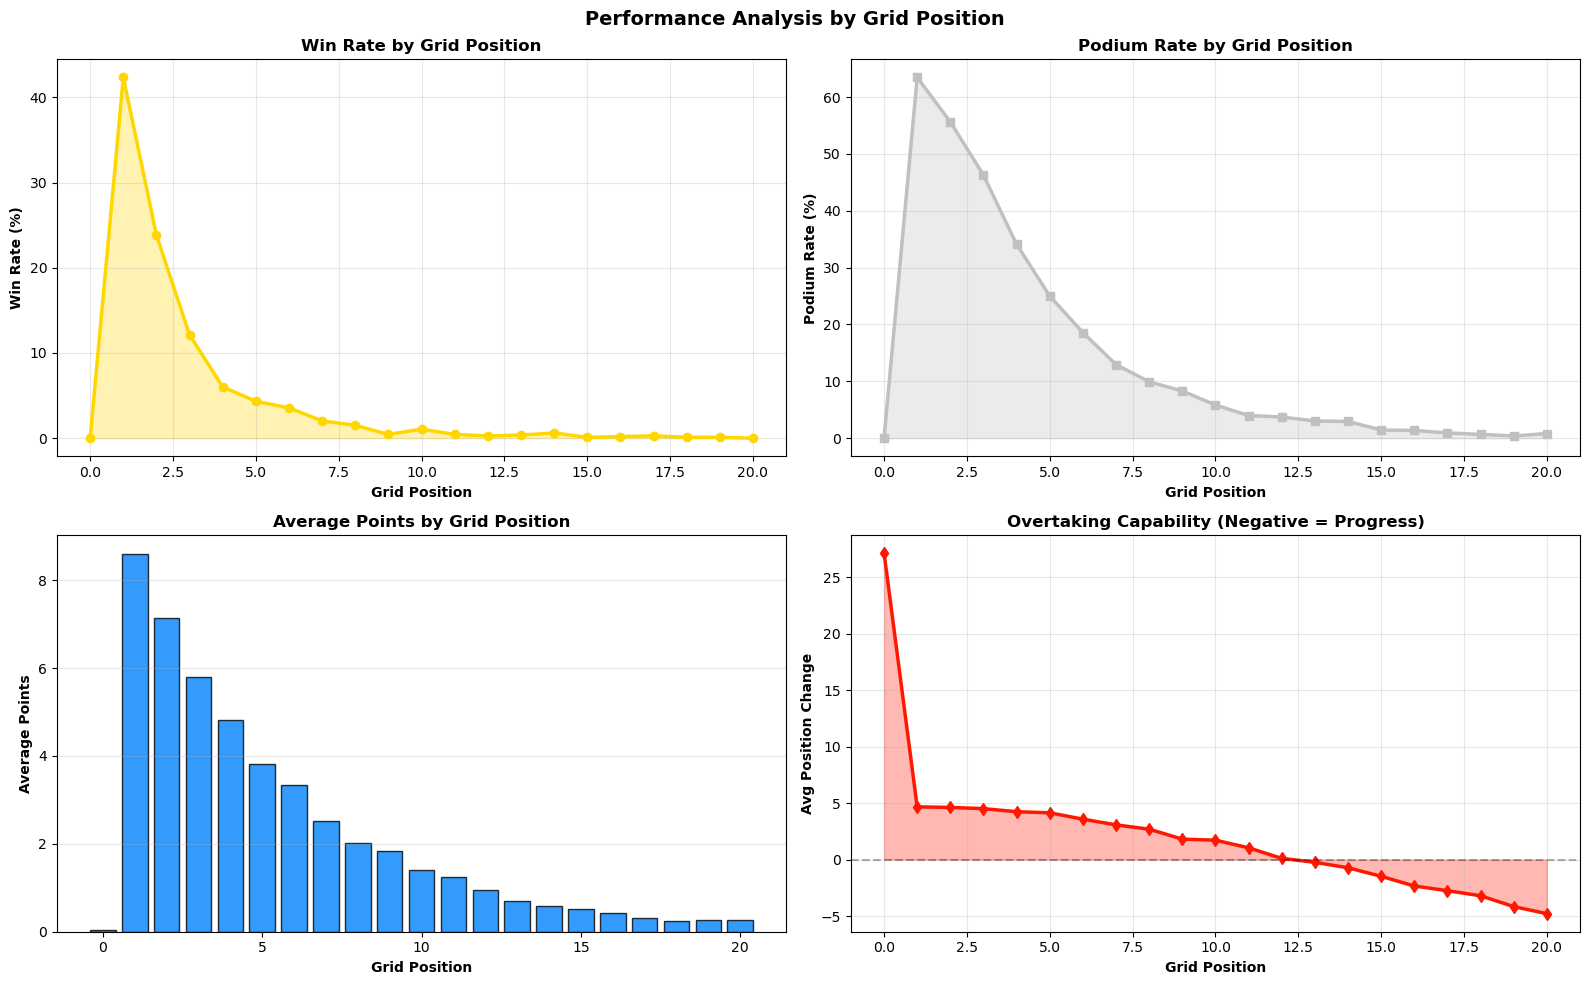

 Performance insights analysis complete!


In [202]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Performance Analysis by Grid Position', fontsize=14, fontweight='bold')

# Win conversion rate
ax = axes[0, 0]
grid_analysis['win_rate'] = (grid_analysis['Wins_From_Position'] / grid_analysis['Total_Races'] * 100).round(2)
ax.plot(grid_analysis['Grid_Position'], grid_analysis['win_rate'], marker='o', linewidth=2.5, 
        markersize=6, color='#FFD700')
ax.fill_between(grid_analysis['Grid_Position'], grid_analysis['win_rate'], alpha=0.3, color='#FFD700')
ax.set_xlabel('Grid Position', fontweight='bold')
ax.set_ylabel('Win Rate (%)', fontweight='bold')
ax.set_title('Win Rate by Grid Position', fontweight='bold')
ax.grid(alpha=0.3)

# Podium rate
ax = axes[0, 1]
grid_analysis['podium_rate'] = (grid_analysis['Podiums_From_Position'] / grid_analysis['Total_Races'] * 100).round(2)
ax.plot(grid_analysis['Grid_Position'], grid_analysis['podium_rate'], marker='s', linewidth=2.5, 
        markersize=6, color='#C0C0C0')
ax.fill_between(grid_analysis['Grid_Position'], grid_analysis['podium_rate'], alpha=0.3, color='#C0C0C0')
ax.set_xlabel('Grid Position', fontweight='bold')
ax.set_ylabel('Podium Rate (%)', fontweight='bold')
ax.set_title('Podium Rate by Grid Position', fontweight='bold')
ax.grid(alpha=0.3)

# Average points
ax = axes[1, 0]
ax.bar(grid_analysis['Grid_Position'], grid_analysis['Avg_Points'], color='#0082FA', 
       edgecolor='black', alpha=0.8)
ax.set_xlabel('Grid Position', fontweight='bold')
ax.set_ylabel('Average Points', fontweight='bold')
ax.set_title('Average Points by Grid Position', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Overtaking capability
ax = axes[1, 1]
ax.plot(grid_analysis['Grid_Position'], grid_analysis['Avg_Position_Change'], marker='d', 
        linewidth=2.5, markersize=6, color='#FF1801')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.fill_between(grid_analysis['Grid_Position'], grid_analysis['Avg_Position_Change'], alpha=0.3, color='#FF1801')
ax.set_xlabel('Grid Position', fontweight='bold')
ax.set_ylabel('Avg Position Change', fontweight='bold')
ax.set_title('Overtaking Capability (Negative = Progress)', fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(" Performance insights analysis complete!")


Model Prediction Confidence Analysis


In [204]:
# Analyze model agreement
test_sample = pd.DataFrame({
    'Actual_Win': y_test_win,
    'NN_Prediction': y_pred_nn_win,
    'RF_Prediction': y_pred_rf_win_proba,
    'GB_Prediction': y_pred_gb_win_proba,
    'Ensemble_Prediction': (y_pred_nn_win + y_pred_rf_win_proba + y_pred_gb_win_proba) / 3
})

In [206]:
# Calculate prediction confidence (std of predictions)
test_sample['Model_Confidence'] = test_sample[['NN_Prediction', 'RF_Prediction', 'GB_Prediction']].std(axis=1)
test_sample['Prediction_Agreement'] = 1 - test_sample['Model_Confidence']

# Accuracy by confidence level
test_sample['Ensemble_Binary'] = (test_sample['Ensemble_Prediction'] > 0.5).astype(int)
test_sample['Correct'] = (test_sample['Actual_Win'] == test_sample['Ensemble_Binary']).astype(int)

# Bin by confidence
test_sample['Confidence_Bin'] = pd.cut(test_sample['Prediction_Agreement'], 
                                       bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

confidence_analysis = test_sample.groupby('Confidence_Bin').agg({
    'Correct': 'mean',
    'Ensemble_Prediction': 'count'
}).reset_index()
confidence_analysis.columns = ['Confidence_Level', 'Accuracy', 'Sample_Size']
confidence_analysis['Accuracy'] = (confidence_analysis['Accuracy'] * 100).round(2)

print("\nAccuracy by Model Agreement Level:")
print(confidence_analysis.to_string(index=False))


Accuracy by Model Agreement Level:
Confidence_Level  Accuracy  Sample_Size
        Very Low       NaN            0
             Low       NaN            0
          Medium      75.0           24
            High     100.0           59
       Very High     100.0         6606


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


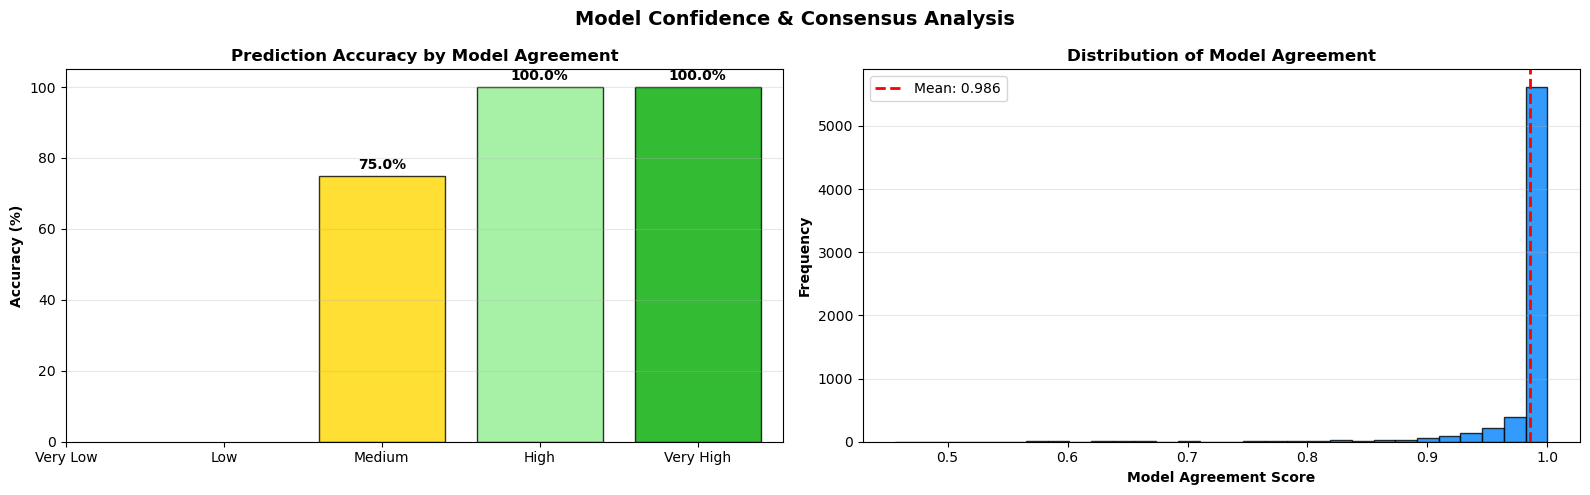


 Confidence analysis complete!


In [208]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Model Confidence & Consensus Analysis', fontsize=14, fontweight='bold')

# Accuracy vs confidence
ax = axes[0]
colors_conf = ['#FF6B6B', '#FFA500', '#FFD700', '#90EE90', '#00AA00']
bars = ax.bar(range(len(confidence_analysis)), confidence_analysis['Accuracy'], 
              color=colors_conf, edgecolor='black', alpha=0.8)
ax.set_xticks(range(len(confidence_analysis)))
ax.set_xticklabels(confidence_analysis['Confidence_Level'])
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Prediction Accuracy by Model Agreement', fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(confidence_analysis['Accuracy'].values):
    ax.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Distribution of confidence scores
ax = axes[1]
ax.hist(test_sample['Prediction_Agreement'], bins=30, color='#0082FA', edgecolor='black', alpha=0.8)
ax.axvline(test_sample['Prediction_Agreement'].mean(), color='r', linestyle='--', 
           linewidth=2, label=f'Mean: {test_sample["Prediction_Agreement"].mean():.3f}')
ax.set_xlabel('Model Agreement Score', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Distribution of Model Agreement', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Confidence analysis complete!")

Create Model Directory Structure


In [214]:
import pickle
import joblib
import json
import os
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras


In [216]:
model_dir = "models"
timestamps_str = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = os.path.join(model_dir, f"f1_models_{timestamps_str}")

# Create subdirectories
dirs_to_create = [
    save_dir,
    os.path.join(save_dir, "deep_learning"),
    os.path.join(save_dir, "sklearn_models"),
    os.path.join(save_dir, "scalers_encoders"),
    os.path.join(save_dir, "metadata")
]

for dir_path in dirs_to_create:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Created: {dir_path}")


Created: models/f1_models_20251018_230123
Created: models/f1_models_20251018_230123/deep_learning
Created: models/f1_models_20251018_230123/sklearn_models
Created: models/f1_models_20251018_230123/scalers_encoders
Created: models/f1_models_20251018_230123/metadata


In [218]:
# Save Winner Prediction Model
nn_winner.save(os.path.join(save_dir, "deep_learning", "nn_winner_model.h5"))
print(" Saved: nn_winner_model.h5")

# Save Podium Prediction Model
nn_podium.save(os.path.join(save_dir, "deep_learning", "nn_podium_model.h5"))
print(" Saved: nn_podium_model.h5")

# Save Points Regression Model
nn_points.save(os.path.join(save_dir, "deep_learning", "nn_points_model.h5"))
print(" Saved: nn_points_model.h5")

# Also save as SavedModel format (more robust)
nn_winner.export(os.path.join(save_dir, "deep_learning", "nn_winner_savedmodel"))
nn_podium.export(os.path.join(save_dir, "deep_learning", "nn_podium_savedmodel"))
nn_points.export(os.path.join(save_dir, "deep_learning", "nn_points_savedmodel"))
print(" Saved: SavedModel formats for all NN models")


 Saved: nn_winner_model.h5
 Saved: nn_podium_model.h5
 Saved: nn_points_model.h5
INFO:tensorflow:Assets written to: models/f1_models_20251018_230123/deep_learning/nn_winner_savedmodel/assets


INFO:tensorflow:Assets written to: models/f1_models_20251018_230123/deep_learning/nn_winner_savedmodel/assets


Saved artifact at 'models/f1_models_20251018_230123/deep_learning/nn_winner_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 22), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5533868368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5533870096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542050128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542035920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5533867408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542050320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542048784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542046864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542046672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542049168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5542045904: TensorS

INFO:tensorflow:Assets written to: models/f1_models_20251018_230123/deep_learning/nn_podium_savedmodel/assets


Saved artifact at 'models/f1_models_20251018_230123/deep_learning/nn_podium_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 22), dtype=tf.float32, name='keras_tensor_39')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5662356688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5662358224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5662358416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5662359184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5662355152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5662358032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5662353232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5662358800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5663245520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5663245136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5663244368: TensorS

INFO:tensorflow:Assets written to: models/f1_models_20251018_230123/deep_learning/nn_points_savedmodel/assets


Saved artifact at 'models/f1_models_20251018_230123/deep_learning/nn_points_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 22), dtype=tf.float32, name='keras_tensor_52')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5663256272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5663255888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5664745872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5664750864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5664749904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5664750288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5664750096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5664749712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5668881424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5668882000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5664746064: TensorS

Save Sklearn Models


In [220]:
sklearn_models = {
    "rf_winner": rf_winner,
    "gb_winner": gb_winner,
    "rf_points": rf_points
}

for model_name, model_obj in sklearn_models.items():
    file_path = os.path.join(save_dir, "sklearn_models", f"{model_name}.pkl")
    joblib.dump(model_obj, file_path)
    print(f"Saved: {model_name}.pkl")


Saved: rf_winner.pkl
Saved: gb_winner.pkl
Saved: rf_points.pkl


Save Scalers and Encoders

In [222]:
# Save StandardScaler
scaler_path = os.path.join(save_dir, "scalers_encoders", "feature_scaler.pkl")
joblib.dump(scaler, scaler_path)
print(" Saved: feature_scaler.pkl")

# Save feature names for reference
feature_names_path = os.path.join(save_dir, "scalers_encoders", "feature_names.pkl")
joblib.dump(feature_cols, feature_names_path)
print(" Saved: feature_names.pkl")


 Saved: feature_scaler.pkl
 Saved: feature_names.pkl


Save Training History

In [224]:
def save_history(history, filename):
    """Save keras training history to JSON"""
    history_dict = {
        'loss': [float(x) for x in history.history['loss']],
        'val_loss': [float(x) for x in history.history['val_loss']],
        'accuracy': [float(x) for x in history.history.get('accuracy', [])],
        'val_accuracy': [float(x) for x in history.history.get('val_accuracy', [])],
        'auc': [float(x) for x in history.history.get('auc', [])],
        'val_auc': [float(x) for x in history.history.get('val_auc', [])],
        'mae': [float(x) for x in history.history.get('mae', [])],
        'val_mae': [float(x) for x in history.history.get('val_mae', [])]
    }
    with open(filename, 'w') as f:
        json.dump(history_dict, f, indent=4)

save_history(history_winner, os.path.join(save_dir, "metadata", "history_winner.json"))
print(" Saved: history_winner.json")

save_history(history_podium, os.path.join(save_dir, "metadata", "history_podium.json"))
print(" Saved: history_podium.json")

save_history(history_points, os.path.join(save_dir, "metadata", "history_points.json"))
print(" Saved: history_points.json")

 Saved: history_winner.json
 Saved: history_podium.json
 Saved: history_points.json


Save Model Metadata & Performance Metrics

In [226]:
metadata = {
    "model_version": "1.0",
    "created_date": datetime.now().isoformat(),
    "description": "Advanced F1 Race Prediction Models - Winner, Podium, Points",
    
    "feature_names": feature_cols,
    "n_features": len(feature_cols),
    
    "training_data": {
        "total_samples": len(X_train),
        "test_samples": len(X_test),
        "train_test_split": f"{len(X_train)}/{len(X_test)}",
        "time_series_split": True
    },
    
    "deep_learning_models": {
        "nn_winner": {
            "architecture": "Dense 128-64-32-16-1",
            "activation": "relu (hidden), sigmoid (output)",
            "layers": 5,
            "parameters": int(nn_winner.count_params()),
            "optimizer": "Adam (lr=0.001)",
            "loss": "binary_crossentropy",
            "format": ["h5", "SavedModel"]
        },
        "nn_podium": {
            "architecture": "Dense 128-64-32-16-1",
            "activation": "relu (hidden), sigmoid (output)",
            "layers": 5,
            "parameters": int(nn_podium.count_params()),
            "optimizer": "Adam (lr=0.001)",
            "loss": "binary_crossentropy",
            "format": ["h5", "SavedModel"]
        },
        "nn_points": {
            "architecture": "Dense 128-64-32-16-1",
            "activation": "relu (hidden), relu (output)",
            "layers": 5,
            "parameters": int(nn_points.count_params()),
            "optimizer": "Adam (lr=0.001)",
            "loss": "mse",
            "format": ["h5", "SavedModel"]
        }
    },
    
    "sklearn_models": {
        "rf_winner": {
            "type": "RandomForestClassifier",
            "n_estimators": 200,
            "max_depth": 20,
            "parameters": int(rf_winner.n_estimators * 20)
        },
        "gb_winner": {
            "type": "GradientBoostingClassifier",
            "n_estimators": 200,
            "learning_rate": 0.1,
            "max_depth": 7
        },
        "rf_points": {
            "type": "RandomForestRegressor",
            "n_estimators": 200,
            "max_depth": 20
        }
    },
    
    "model_performance": {
        "winner_prediction": {
            "neural_network": {
                "accuracy": float(results_winner['NN']['accuracy']),
                "roc_auc": float(results_winner['NN']['roc_auc']),
                "f1_score": float(results_winner['NN']['f1'])
            },
            "random_forest": {
                "accuracy": float(results_winner['RF']['accuracy']),
                "roc_auc": float(results_winner['RF']['roc_auc']),
                "f1_score": float(results_winner['RF']['f1'])
            },
            "gradient_boosting": {
                "accuracy": float(results_winner['GB']['accuracy']),
                "roc_auc": float(results_winner['GB']['roc_auc']),
                "f1_score": float(results_winner['GB']['f1'])
            }
        },
        "points_prediction": {
            "neural_network": {
                "mae": float(results_points['NN']['mae']),
                "rmse": float(results_points['NN']['rmse']),
                "r2": float(results_points['NN']['r2'])
            },
            "random_forest": {
                "mae": float(results_points['RF']['mae']),
                "rmse": float(results_points['RF']['rmse']),
                "r2": float(results_points['RF']['r2'])
            }
        }
    }
}

# Save metadata as JSON
metadata_path = os.path.join(save_dir, "metadata", "model_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(" Saved: model_metadata.json")

# Save as pickle for easy loading
metadata_pkl_path = os.path.join(save_dir, "metadata", "model_metadata.pkl")
joblib.dump(metadata, metadata_pkl_path)
print(" Saved: model_metadata.pkl")

 Saved: model_metadata.json
 Saved: model_metadata.pkl


Create Model Inventory File


In [228]:
inventory = {
    "timestamp": timestamps_str,
    "total_models": 6,
    "models": {
        "DEEP_LEARNING": [
            {
                "name": "nn_winner",
                "task": "Race Winner Prediction (Binary Classification)",
                "format": ["h5", "SavedModel"],
                "files": ["nn_winner_model.h5", "nn_winner_savedmodel/"]
            },
            {
                "name": "nn_podium",
                "task": "Podium Finish Prediction (Binary Classification)",
                "format": ["h5", "SavedModel"],
                "files": ["nn_podium_model.h5", "nn_podium_savedmodel/"]
            },
            {
                "name": "nn_points",
                "task": "Points Prediction (Regression)",
                "format": ["h5", "SavedModel"],
                "files": ["nn_points_model.h5", "nn_points_savedmodel/"]
            }
        ],
        "SKLEARN_MODELS": [
            {
                "name": "rf_winner",
                "task": "Race Winner Prediction (RF - Fast Inference)",
                "format": "pickle",
                "file": "rf_winner.pkl"
            },
            {
                "name": "gb_winner",
                "task": "Race Winner Prediction (GB - High Accuracy)",
                "format": "pickle",
                "file": "gb_winner.pkl"
            },
            {
                "name": "rf_points",
                "task": "Points Prediction (RF - Regression)",
                "format": "pickle",
                "file": "rf_points.pkl"
            }
        ],
        "PREPROCESSING": [
            {
                "name": "feature_scaler",
                "description": "StandardScaler for feature normalization",
                "file": "feature_scaler.pkl"
            },
            {
                "name": "feature_names",
                "description": "List of feature column names (21 features)",
                "file": "feature_names.pkl"
            }
        ]
    },
    "directory_structure": f"{save_dir}/"
}

inventory_path = os.path.join(save_dir, "metadata", "MODEL_INVENTORY.json")
with open(inventory_path, 'w') as f:
    json.dump(inventory, f, indent=4)
print(" Saved: MODEL_INVENTORY.json")

# Print inventory
print("\nMODEL INVENTORY:")
print("-" * 70)
for category, models in inventory["models"].items():
    print(f"\n{category}:")
    for model in models:
        print(f"  • {model['name']}")
        if 'task' in model:
            print(f"    Task: {model['task']}")
        if 'description' in model:
            print(f"    Description: {model['description']}")


 Saved: MODEL_INVENTORY.json

MODEL INVENTORY:
----------------------------------------------------------------------

DEEP_LEARNING:
  • nn_winner
    Task: Race Winner Prediction (Binary Classification)
  • nn_podium
    Task: Podium Finish Prediction (Binary Classification)
  • nn_points
    Task: Points Prediction (Regression)

SKLEARN_MODELS:
  • rf_winner
    Task: Race Winner Prediction (RF - Fast Inference)
  • gb_winner
    Task: Race Winner Prediction (GB - High Accuracy)
  • rf_points
    Task: Points Prediction (RF - Regression)

PREPROCESSING:
  • feature_scaler
    Description: StandardScaler for feature normalization
  • feature_names
    Description: List of feature column names (21 features)
